# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import os
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../input/train_macro.csv', index_col=0)
df_test_macro = pd.read_csv('../input/test_macro.csv', index_col=0)

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     111.3
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:24:42   Log-Likelihood:                -19214.
No. Observations:               30404   AIC:                         3.883e+04
Df Residuals:                   30205   BIC:                         4.048e+04
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0482      0.019      2.587      0.010       0.012       0.085
C(_ecology)[T.good]                                        0.0059      0.028      0.214      0.831      -0.048       0.060
C(_ecology)[T.no data]                                     0.0863      0.057      1.508      0.131      -0.026       0.198
C(_ecology)[T.poor]                                       -0.0188      0.020     -0.945      0.345      -0.058       0.020
C(_ecology)[T.satisfactory]                               -0.0306      0.027     -1.117      0.264      -0.084       0.023
C(_product_type)[T.OwnerOccupier]                          0.1486      0.013     11.445      0.000       0.123       0.174
C(_nuclear_reactor_raion)[T.yes]                           0.0851      0.032      2.643      0.008       0.022       0.148
C(_thermal_power_plant_raion)[T.yes]                      -0.0344      0.025     -1.375      0.169      -0.084       0.015
C(_railroad_1line)[T.yes]                                 -0.0941      0.020     -4.748      0.000      -0.133      -0.055
C(_culture_objects_top_25)[T.yes]                          0.0155      0.026      0.595      0.552      -0.036       0.067
C(_radiation_raion)[T.yes]                                -0.0402      0.013     -3.037      0.002      -0.066      -0.014
C(_big_road1_1line)[T.yes]                                -0.0401      0.020     -1.966      0.049      -0.080      -0.000
C(_big_market_raion)[T.yes]                                0.0862      0.025      3.414      0.001       0.037       0.136
C(_detention_facility_raion)[T.yes]                        0.0379      0.021      1.839      0.066      -0.002       0.078
C(_water_1line)[T.yes]                                     0.0016      0.013      0.118      0.906      -0.024       0.027
C(_railroad_terminal_raion)[T.yes]                         0.0359      0.035      1.017      0.309      -0.033       0.105
C(_oil_chemistry_raion)[T.yes]                            -0.0099      0.050     -0.197      0.844      -0.108       0.088
C(_incineration_raion)[T.yes]                             -0.0013      0.036     -0.036      0.971      -0.072       0.069
np.log(_usdrub)                                            0.1271      0.009     13.572      0.000       0.109       0.146
np.log(_full_sq)                                           0.1274      0.128      0.999      0.318      -0.123       0.377
np.log(_life_sq)                                           0.0664      0.030      2.235      0.025       0.008       0.125
_floor                                                     0.0081      0.002      5.191      0.000       0.005       0.011
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     77.01
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:26:15   Log-Likelihood:                -19174.
No. Observations:               30404   AIC:                         3.892e+04
Df Residuals:                   30116   BIC:                         4.132e+04
Df Model:                         287                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5513      0.026    593.179      0.000      15.500      15.603
C(_ecology)[T.good]                                              -0.0012      0.028     -0.042      0.967      -0.056       0.054
C(_ecology)[T.no data]                                            0.0797      0.058      1.374      0.169      -0.034       0.193
C(_ecology)[T.poor]                                              -0.0231      0.020     -1.149      0.250      -0.062       0.016
C(_ecology)[T.satisfactory]                                      -0.0347      0.028     -1.254      0.210      -0.089       0.020
C(_product_type)[T.OwnerOccupier]                                 0.1525      0.013     11.799      0.000       0.127       0.178
C(_nuclear_reactor_raion)[T.yes]                                  0.0943      0.033      2.878      0.004       0.030       0.158
C(_thermal_power_plant_raion)[T.yes]                             -0.0399      0.025     -1.574      0.115      -0.090       0.010
C(_railroad_1line)[T.yes]                                        -0.0931      0.020     -4.637      0.000      -0.132      -0.054
C(_culture_objects_top_25)[T.yes]                                 0.0158      0.026      0.601      0.548      -0.036       0.067
C(_radiation_raion)[T.yes]                                       -0.0433      0.013     -3.256      0.001      -0.069      -0.017
C(_big_road1_1line)[T.yes]                                       -0.0376      0.020     -1.861      0.063      -0.077       0.002
C(_big_market_raion)[T.yes]                                       0.0827      0.026      3.238      0.001       0.033       0.133
C(_detention_facility_raion)[T.yes]                               0.0369      0.021      1.784      0.074      -0.004       0.078
C(_water_1line)[T.yes]                                            0.0021      0.013      0.163      0.870      -0.023       0.028
C(_railroad_terminal_raion)[T.yes]                                0.0399      0.036      1.119      0.263      -0.030       0.110
C(_oil_chemistry_raion)[T.yes]                                   -0.0154      0.051     -0.305      0.760      -0.114       0.084
C(_incineration_raion)[T.yes]                                     0.0120      0.037      0.324      0.746      -0.060       0.084
scale(np.log(_usdrub))                                            0.9473      0.107      8.818      0.000       0.737       1.158
scale(np.log(_full_sq))                                           0.0220      0.045      0.492      0.623      -0.066       0.109
scale(np.log(_life_sq))                                           0.0332      0.018      1.86

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_ecology),1.701864,4.0,2.039157,8.603509e-02
C(_product_type),29.048339,1.0,139.221730,4.635197e-32
C(_nuclear_reactor_raion),1.727673,1.0,8.280322,4.010518e-03
C(_thermal_power_plant_raion),0.517114,1.0,2.478404,1.154298e-01
C(_railroad_1line),4.485373,1.0,21.497316,3.558102e-06
C(_culture_objects_top_25),0.075404,1.0,0.361396,5.477367e-01
C(_radiation_raion),2.212254,1.0,10.602803,1.130412e-03
C(_big_road1_1line),0.722314,1.0,3.461877,6.280871e-02
C(_big_market_raion),2.187256,1.0,10.482996,1.206086e-03
C(_detention_facility_raion),0.663960,1.0,3.182200,7.445452e-02



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     335.5
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:30:48   Log-Likelihood:                -19603.
No. Observations:               30404   AIC:                         3.933e+04
Df Residuals:                   30341   BIC:                         3.986e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              15.5716      0.006   2791.980      0.000      15.561      15.583
C(_product_type)[T.OwnerOccupier]                       0.1586      0.010     15.766      0.000       0.139       0.178
C(_railroad_1line)[T.yes]                              -0.1434      0.018     -8.182      0.000      -0.178      -0.109
C(_radiation_raion)[T.yes]                             -0.0575      0.008     -7.503      0.000      -0.073      -0.042
C(_big_market_raion)[T.yes]                             0.0839      0.014      5.834      0.000       0.056       0.112
scale(np.log(_usdrub))                                  0.9769      0.105      9.268      0.000       0.770       1.184
scale(_floor)                                           0.0468      0.008      5.727      0.000       0.031       0.063
scale(_state)                                          -0.1154      0.016     -7.163      0.000      -0.147      -0.084
scale(np.log(_area_m))                                  0.8058      0.123      6.525      0.000       0.564       1.048
scale(_preschool_education_centers_raion)              -0.0427      0.012     -3.548      0.000      -0.066      -0.019
scale(_school_education_centers_raion)                  0.0934      0.017      5.432      0.000       0.060       0.127
scale(np.log(_university_top_20_raion))                 0.0888      0.021      4.212      0.000       0.047       0.130
scale(np.log(_build_count_before_1920))                -0.0187      0.005     -3.739      0.000      -0.029      -0.009
scale(np.log(_railroad_station_walk_min))               0.0367      0.018      2.075      0.038       0.002       0.071
scale(np.log(_public_transport_station_min_walk))      -0.0166      0.004     -4.161      0.000      -0.024      -0.009
scale(np.log(_kremlin_km))                              0.1878      0.011     16.982      0.000       0.166       0.210
scale(_big_road2_km)                                   -0.0479      0.010     -4.656      0.000      -0.068      -0.028
scale(np.log(_zd_vokzaly_avto_km))                      0.0765      0.015      5.049      0.000       0.047       0.106
scale(np.log(_power_transmission_line_km))              0.0217      0.005      4.391      0.000       0.012       0.031
scale(np.log(_market_shop_km))                         -0.0168      0.005     -3.278      0.001      -0.027      -0.007
scale(np.log(_workplaces_km))                          -0.0165      0.006     -2.936      0.003      -0.027      -0.005
scale(np.log(_additional_education_km))                -0.0180      0.004     -4.373      0.000      -0.026      -0.010
scale(np.log(_preschool_km))                           -0.0163      0.006     -2.75

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     3509.
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:31:40   Log-Likelihood:                 14770.
No. Observations:               26716   AIC:                        -2.941e+04
Df Residuals:                   26653   BIC:                        -2.890e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              15.7566      0.002   8244.760      0.000      15.753      15.760
C(_product_type)[T.OwnerOccupier]                      -0.0482      0.003    -14.529      0.000      -0.055      -0.042
C(_railroad_1line)[T.yes]                              -0.1557      0.006    -26.055      0.000      -0.167      -0.144
C(_radiation_raion)[T.yes]                             -0.0375      0.003    -14.817      0.000      -0.042      -0.033
C(_big_market_raion)[T.yes]                             0.0438      0.005      9.374      0.000       0.035       0.053
scale(np.log(_usdrub))                                  0.6733      0.034     19.691      0.000       0.606       0.740
scale(_floor)                                           0.0604      0.003     21.823      0.000       0.055       0.066
scale(_state)                                          -0.0979      0.005    -18.767      0.000      -0.108      -0.088
scale(np.log(_area_m))                                  0.7588      0.041     18.310      0.000       0.678       0.840
scale(_preschool_education_centers_raion)              -0.0547      0.004    -13.525      0.000      -0.063      -0.047
scale(_school_education_centers_raion)                  0.1096      0.006     19.041      0.000       0.098       0.121
scale(np.log(_university_top_20_raion))                 0.0275      0.007      3.761      0.000       0.013       0.042
scale(np.log(_build_count_before_1920))                -0.0043      0.002     -2.701      0.007      -0.007      -0.001
scale(np.log(_railroad_station_walk_min))               0.0140      0.006      2.378      0.017       0.002       0.026
scale(np.log(_public_transport_station_min_walk))      -0.0216      0.001    -16.281      0.000      -0.024      -0.019
scale(np.log(_kremlin_km))                              0.1700      0.004     44.604      0.000       0.163       0.178
scale(_big_road2_km)                                   -0.0417      0.003    -12.211      0.000      -0.048      -0.035
scale(np.log(_zd_vokzaly_avto_km))                      0.0690      0.006     11.373      0.000       0.057       0.081
scale(np.log(_power_transmission_line_km))              0.0268      0.002     16.245      0.000       0.024       0.030
scale(np.log(_market_shop_km))                         -0.0054      0.002     -3.181      0.001      -0.009      -0.002
scale(np.log(_workplaces_km))                          -0.0128      0.002     -6.811      0.000      -0.016      -0.009
scale(np.log(_additional_education_km))                 0.0040      0.001      2.963      0.003       0.001       0.007
scale(np.log(_preschool_km))                           -0.0135      0.002     -6.82

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     6352.
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:31:56   Log-Likelihood:                 17327.
No. Observations:               25037   AIC:                        -3.457e+04
Df Residuals:                   24996   BIC:                        -3.424e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             15.7469      0.002   9781.875      0.000      15.744      15.750
C(_product_type)[T.OwnerOccupier]                     -0.0468      0.003    -16.567      0.000      -0.052      -0.041
C(_railroad_1line)[T.yes]                             -0.1747      0.006    -31.193      0.000      -0.186      -0.164
C(_radiation_raion)[T.yes]                            -0.0170      0.002     -7.956      0.000      -0.021      -0.013
scale(np.log(_usdrub))                                 0.0498      0.001     63.521      0.000       0.048       0.051
scale(_floor)                                          0.0607      0.003     24.148      0.000       0.056       0.066
scale(_preschool_education_centers_raion)             -0.0506      0.004    -14.394      0.000      -0.057      -0.044
scale(_school_education_centers_raion)                 0.1189      0.005     24.512      0.000       0.109       0.128
scale(np.log(_university_top_20_raion))                0.0058      0.001      5.117      0.000       0.004       0.008
scale(np.log(_public_transport_station_min_walk))     -0.0224      0.001    -19.399      0.000      -0.025      -0.020
scale(np.log(_kremlin_km))                             0.1270      0.002     51.514      0.000       0.122       0.132
scale(np.log(_zd_vokzaly_avto_km))                    -0.0090      0.003     -2.826      0.005      -0.015      -0.003
scale(np.log(_power_transmission_line_km))             0.0282      0.001     23.013      0.000       0.026       0.031
scale(np.log(_workplaces_km))                         -0.0088      0.002     -5.253      0.000      -0.012      -0.005
scale(np.log(_additional_education_km))                0.0056      0.001      4.881      0.000       0.003       0.008
scale(np.log(_preschool_km))                          -0.0038      0.002     -2.345      0.019      -0.007      -0.001
scale(np.log(_trc_count_2000))                         0.0321      0.003      9.194      0.000       0.025       0.039
scale(np.log(_cafe_sum_2000_max_price_avg))            0.0111      0.001     11.979      0.000       0.009       0.013
scale(np.log(_sport_count_2000))                       0.0245      0.002     12.254      0.000       0.021       0.028
scale(np.log(_leisure_count_3000))                     0.0135      0.002      8.769      0.000       0.011       0.017
scale(_trc_count_5000)                                 0.0252      0.003      9.694      0.000       0.020       0.030
scale(np.log(_mosque_count_5000))                      0.0133      0.001     12.112      0.000       0.011       0.016
scale(I(np.log(_full_sq) ** 2))                        0.2831      0.001    350.663      0.000       0.281  

# 5. Diagnosis of Regression
## Residual Normality Test

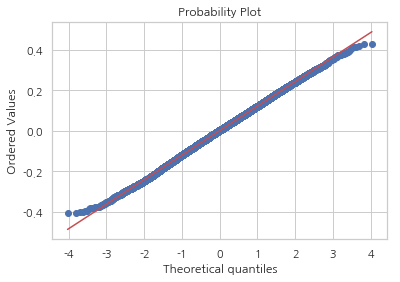

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 12.844
P-value     :  0.002


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

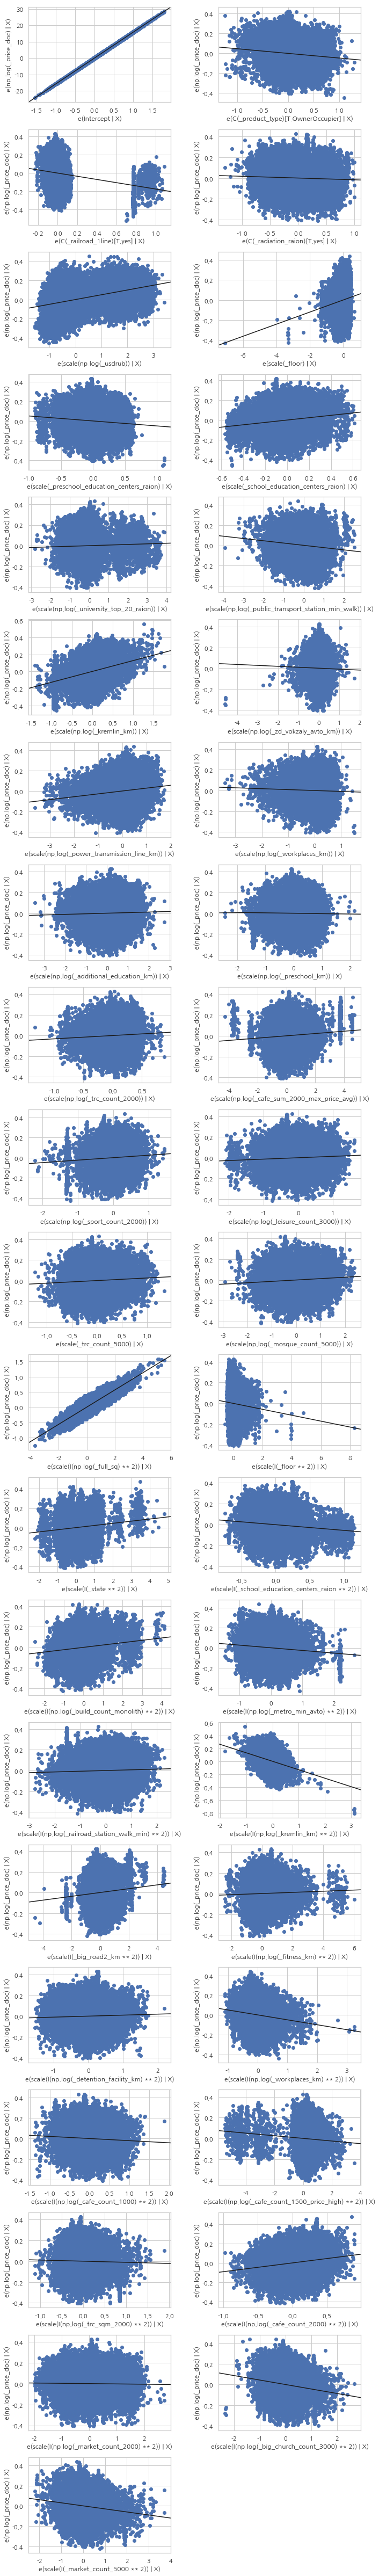

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.38501122618851663

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  2.,  2.,  0.,  0.,  0.,  4.,  0.,
         2.,  4.,  3.,  2.,  3.,  2.,  6.,  7.,  4., 12., 10.,  5.,  9.,
         9., 17.,  9.,  8., 17.,  8., 20., 16., 19., 33., 18., 19., 21.,
        22., 34., 21., 30., 21., 35., 30., 22., 25., 39., 43., 29., 27.,
        30., 36., 16., 26., 27., 19., 23., 16., 17., 14., 20., 16.,  8.,
        16.,  8.,  7.,  5.,  4.,  4.,  3.,  5.,  2.]),
 array([-0.76872755, -0.75248733, -0.73624711, -0.72000689, -0.70376667,
        -0.68752646, -0.67128624, -0.65504602, -0.6388058 , -0.62256558,
        -0.60632536, -0.59008515, -0.57384493, -0.55760471, -0.54136449,
        -0.52512427, -0.50888405, -0.49264384, -0.47640362, -0.4601634 ,
        -0.44392318, -0.42768296, -0.41144275, -0.39520253, -0.37896231,
        -0.36272209, -0.34648187, -0.33024165, -0.31400144, -0.297761

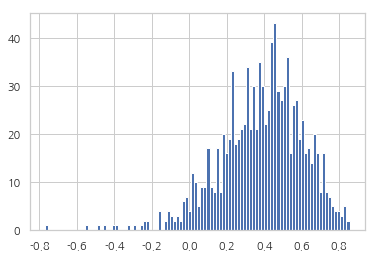

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

0.39701